### Imputation Model for Glucose Values Out of Measuring Range for Continuous Glucose Monitors

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_processing import (
    load_data,
    apply_quantile_cut,
    get_continuous_segments_loc,
    clean_segment_and_align,
)
from src.visualization import (
    plot_patient_data_with_quantile,
    visualize_original_interpolated,
)
from models.baselines import naive_baseline_imputation
from models.gp import train_gpr, inference_gpr
from bg_statistics import (
    calculate_segment_statistics,
    calculate_mean_sd,
    compare_statistics,
)

In [31]:
patient_ids = ['540', '544', '552', '559', '563', '567', '570', '575', '584', '588', '591', '596']
train_data_dict = {}
test_data_dict = {}
all_data_dict = {}
for patient_id in patient_ids:
    _, train_data, test_data, all_data = load_data(patient_id, include_test=True)
    train_data_dict[patient_id] = train_data
    test_data_dict[patient_id] = test_data
    all_data_dict[patient_id] = all_data

**Calculate 80th percentile from all the data**<br>
We applied an 80th percentile cutoff to each patient's CGM data, simulating the upper detection limit of CGM devices. This threshold is used to reserve higher glucose values for testing, the threshold are saved in a list.

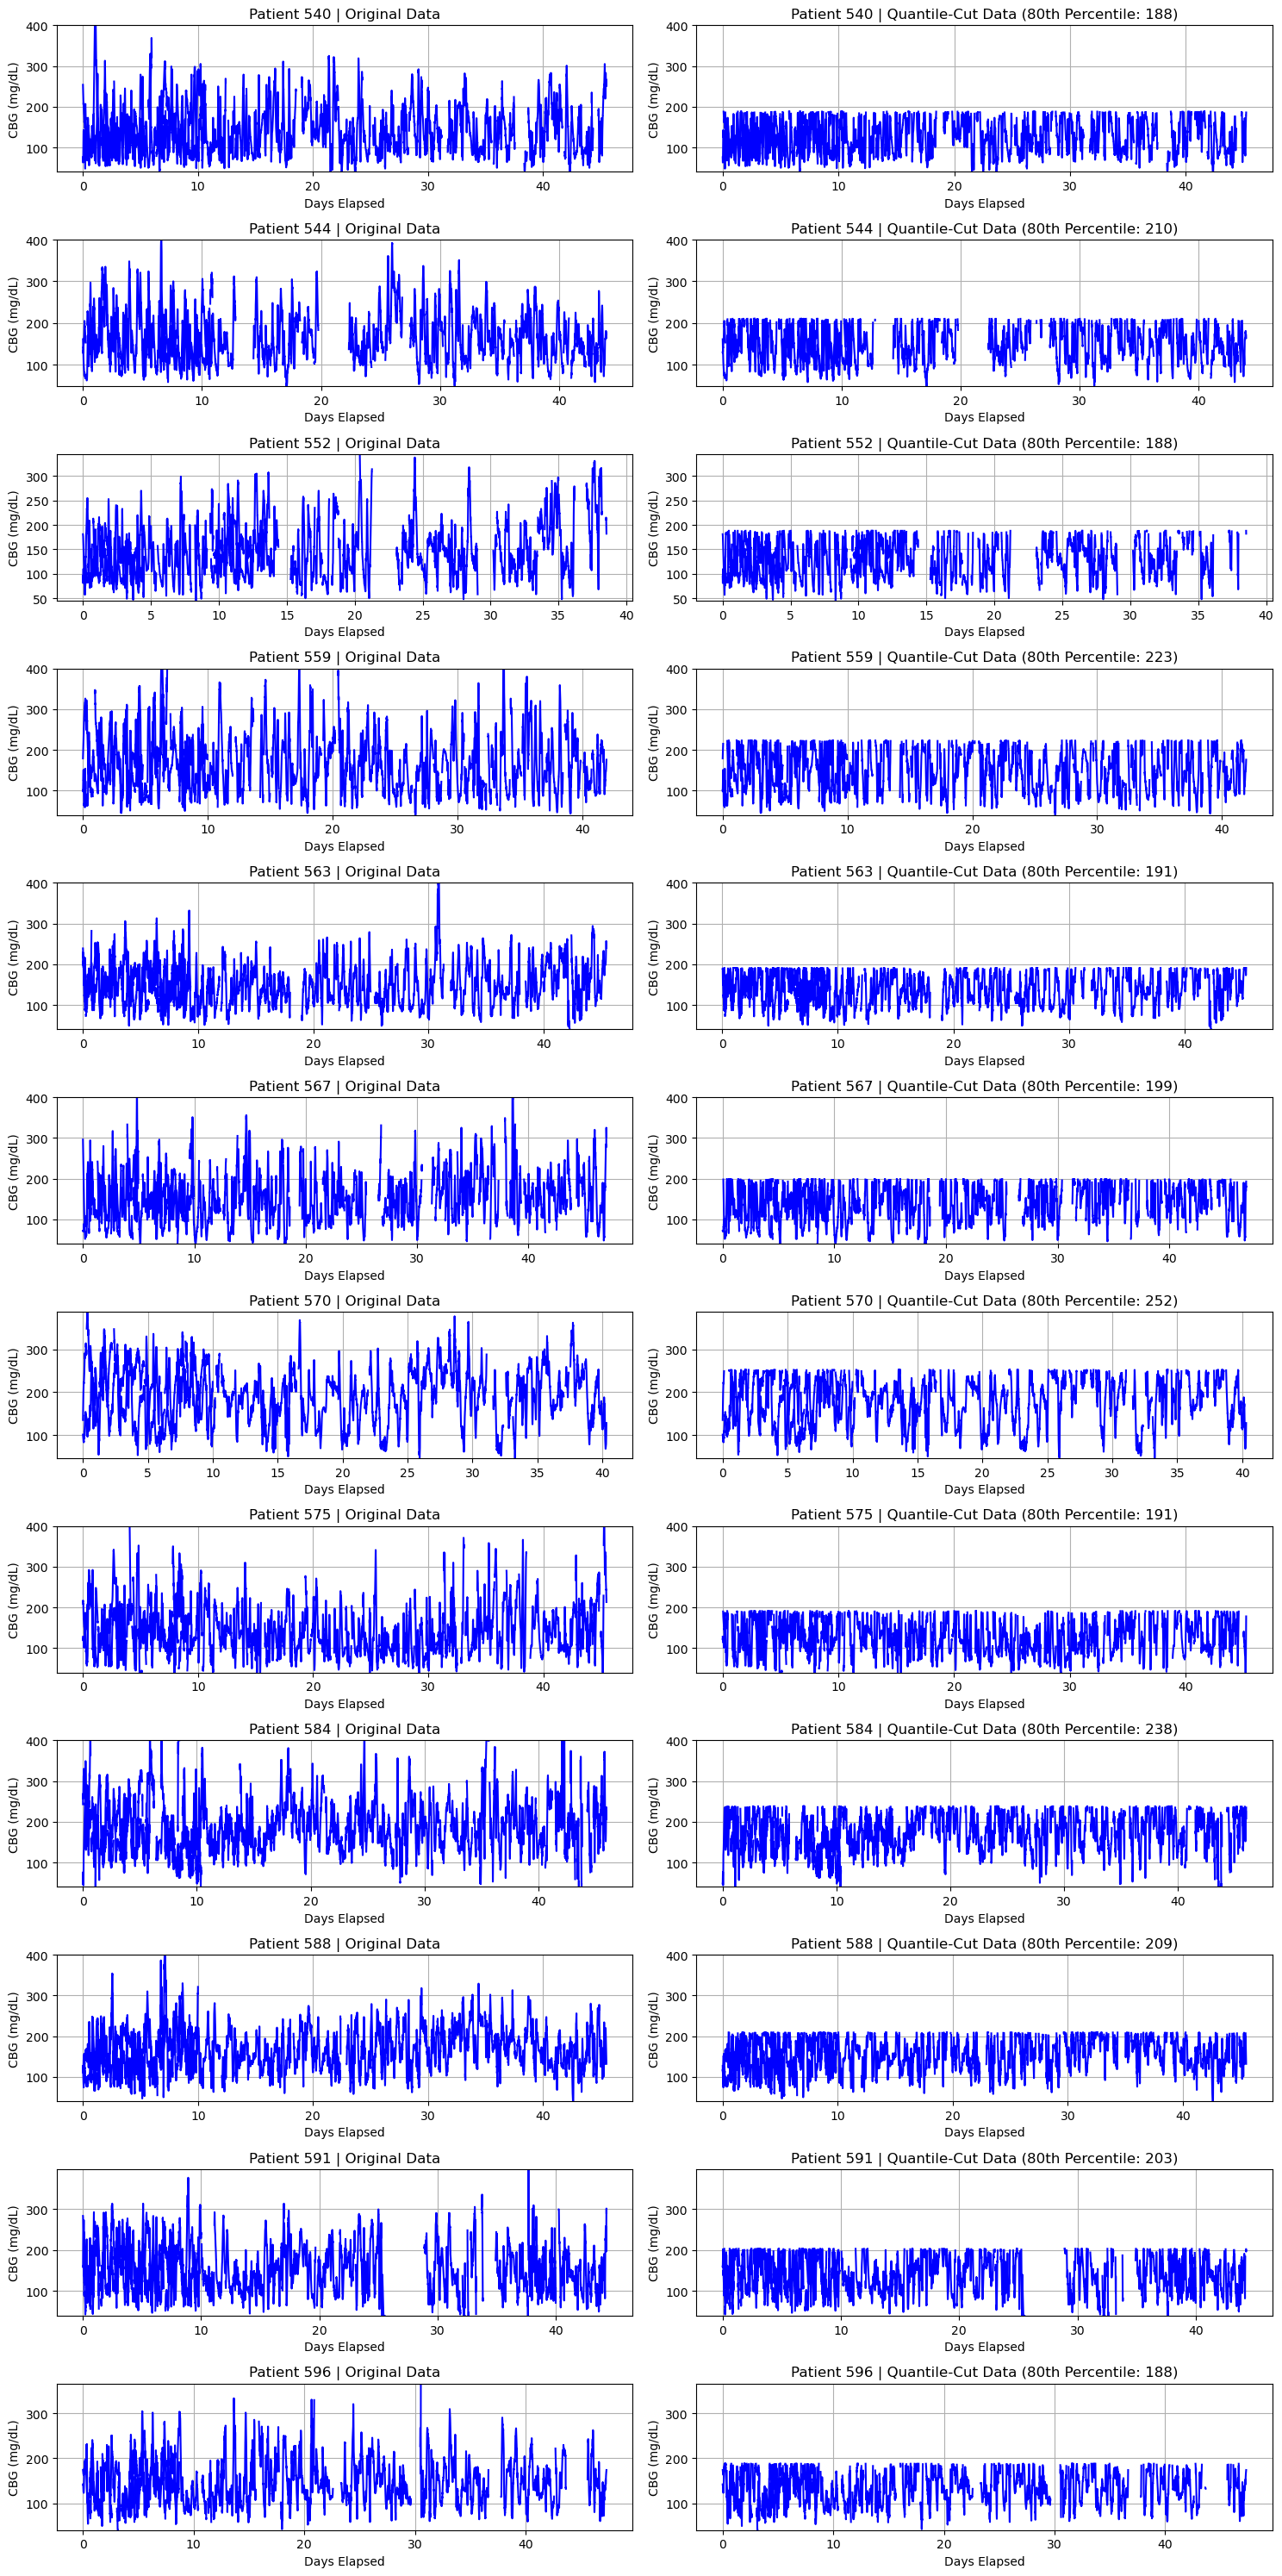

In [32]:
quantile_cut_data, thresh_data = apply_quantile_cut(all_data_dict, nan_above_quantile=0.8)
plot_patient_data_with_quantile(all_data_dict, quantile_cut_data, quantile_cutoff=0.8)

**Segmentation and Visualization** <br>
This process creates two key outputs: <br>
&nbsp;&nbsp;&nbsp;&nbsp;1. Continuous Segments: These are periods where CGM data is continuously recorded without any missing values. Extract all the continuous segments from the data, in order to avoid actual missing data <br> <br>
&nbsp;&nbsp;&nbsp;&nbsp;2. Censor each continuous segment using the 80th percentile calculated using all the data <br> <br>
&nbsp;&nbsp;&nbsp;&nbsp;3. If there are any censored values in the beginning and end of censored segment, we discard these values from the segment <br>
<br>
We have visualized both the continuous CGM data (in blue) and the missing segments (in red) to provide a clear understanding of the data structure and gaps for all 12 patients.


In [33]:
# 1. create continues
cont_segments_dict = {}

for patient_id in patient_ids:
    patient_data = all_data_dict
    cont_segments_loc = get_continuous_segments_loc({patient_id: patient_data[patient_id]}, 'cbg')
    cont_segments_dict[patient_id] = cont_segments_loc[patient_id]  

segments_stats_df = calculate_segment_statistics(cont_segments_dict)
segments_stats_df

num_cont_seg  min_cont_length  max_cont_length  70_percent_cont_length
540          39.0             24.0            946.0                   360.6
544          30.0              3.0           1704.0                   564.3
552          56.0             10.0            578.0                   235.5
559          55.0             21.0           1291.0                   256.6
563          26.0             36.0           1726.0                   600.0
567          70.0              7.0            509.0                   252.1
570          31.0             28.0           1632.0                   659.0
575          84.0              9.0            661.0                   178.3
584          76.0              4.0            939.0                   246.0
588          14.0              8.0           1721.0                  1652.5
591          32.0              7.0           1361.0                   507.6
596          34.0              8.0           1715.0                   440.0

In [34]:
# extract the original segments before censoring

# Dictionary for storing the interpolated data for each patient
original_segments = {}

# Assuming 'original_data' is a dictionary with patient data, and each entry is a 1D array of continuous data points
for patient_id, segments_info in cont_segments_dict.items():
    start_indices = segments_info['start_indices']
    end_indices = segments_info['end_indices']
    
    # Store interpolated segments for the current patient
    original_segments[patient_id] = []
    
    for start, end in zip(start_indices, end_indices):
        # Extract the segment data between the start and end indices
        segment_data = all_data_dict[patient_id]['cbg'][start:end + 1]
        original_segments[patient_id].append(np.array(segment_data))

In [35]:
# 2. censored segments
# Dictionary for storing the interpolated data for each patient
censored_segments = {}

# Assuming 'original_data' is a dictionary with patient data, and each entry is a 1D array of continuous data points
for patient_id, segments_info in cont_segments_dict.items():
    start_indices = segments_info['start_indices']
    end_indices = segments_info['end_indices']
    
    # Store interpolated segments for the current patient
    censored_segments[patient_id] = []
    
    for start, end in zip(start_indices, end_indices):
        # Extract the segment data between the start and end indices
        segment_data = all_data_dict[patient_id]['cbg'][start:end + 1]
        has_nan = np.isnan(segment_data).any()
        # print("Contains NaN values:", has_nan)
        censored_segment = np.where(segment_data > thresh_data[patient_id], np.nan, segment_data)
        censored_segments[patient_id].append(censored_segment)
        
# print("All censored segments:", censored_segments)

In [36]:
# 3. clean segments

# Function to remove leading and trailing NaN values, while keeping the corresponding values in original_segments
def clean_segment_and_align(censored_segment, original_segment):
    # Remove leading NaNs
    start_idx = 0
    while start_idx < len(censored_segment) and np.isnan(censored_segment[start_idx]):
        start_idx += 1
    
    # Remove trailing NaNs
    end_idx = len(censored_segment) - 1
    while end_idx >= 0 and np.isnan(censored_segment[end_idx]):
        end_idx -= 1
    
    # Slice the segments to match the cleaned portion
    cleaned_censored_segment = censored_segment[start_idx:end_idx + 1]
    cleaned_original_segment = original_segment[start_idx:end_idx + 1]
    
    # Return the cleaned segments from both sensored and original data
    return cleaned_censored_segment, cleaned_original_segment

# Assuming sensored_segments and original_segments are dictionaries containing segments
# Initialize cleaned versions of both dictionaries
cleaned_censored_segments = {}
cleaned_original_segments = {}

# Iterate through each patient in sensored_segments and original_segments
for patient_id in censored_segments.keys():
    # Initialize lists to store cleaned segments
    cleaned_censored_segments[patient_id] = []
    cleaned_original_segments[patient_id] = []
    
    # Process each segment in sensored_segments and original_segments
    for censored_segment, original_segment in zip(censored_segments[patient_id], original_segments[patient_id]):
        cleaned_censored_segment, cleaned_original_segment = clean_segment_and_align(censored_segment, original_segment)
        
        # Append the cleaned segments
        if cleaned_censored_segment.shape[0] != 0 and cleaned_original_segment.shape[0] != 0:
            cleaned_censored_segments[patient_id].append(cleaned_censored_segment)
        if cleaned_original_segment.shape[0] != 0 and cleaned_censored_segment.shape[0] != 0:
            cleaned_original_segments[patient_id].append(cleaned_original_segment)

# Now the cleaned_sensored_segments and cleaned_original_segments dictionaries
# contain segments without leading or trailing NaN values, and they are aligned.
# print("Cleaned Sensored Segments:", cleaned_sensored_segments)
# print("Cleaned Original Segments:", cleaned_original_segments)


**Naive Baseline**<br>
The first model we apply is basic interpolation techniques as a benchmark. We fit the polynomials and cubic splines to the non-missing glucose values and predict the missing values. The following visualizations allow us to assess how well this interpolation predicts missing glucose values for each patient across different segments.

In [37]:
def naive_baseline_imputation(data, method='polynomial', order=2):
    interpolated_segments = {}
    method = 'polynomial'
    # Assuming 'original_data' is a dictionary with patient data, and each entry is a 1D array of continuous data points
    for patient_id, segments in data.items():
        interpolated_segments[patient_id] = []

        for segment in segments:
            # Convert segment to DataFrame to use interpolation functions
            segment_df = pd.DataFrame(segment, columns=['cbg'])
            if method == 'polynomial':
                interpolated_segment = segment_df.interpolate(method='polynomial', order=2)
            else:  # Use 'cubic' for cubic spline interpolation
                interpolated_segment = segment_df.interpolate(method='cubic')
            
            interpolated_segments[patient_id].append(interpolated_segment['cbg'].values)
        
    return interpolated_segments

In [38]:
def visualize_original_interpolated(interpolated_segments, cleaned_censored_segments, cleaned_original_segments, method_name = 'Polynomian'):
    """Visualize original and interpolated test data segments for each patient."""
    fig, axes = plt.subplots(nrows=12, ncols=2, figsize=(15, 30))
    axes = axes.flatten()


    for i, patient_id in enumerate(cleaned_original_segments.keys()):
        if i * 2 + 1 >= len(axes):
            break 

        original_segment = np.concatenate(cleaned_censored_segments[patient_id])
        interpolated_segment = np.concatenate(interpolated_segments[patient_id])
        original_patient_data = np.concatenate(cleaned_original_segments[patient_id])
        y_min = min(interpolated_segment.min(), original_segment.min(), original_patient_data.min())
        y_max = max(interpolated_segment.max(), original_segment.max(), original_patient_data.max())

        
        axes[2 * i + 1].plot(interpolated_segment, color='orange', label='Interpolated Data', alpha=0.8)
        axes[2 * i + 1].plot(original_segment, color='purple', label='Original Data')
        axes[2 * i + 1].set_ylim([y_min, y_max])  # Set shared y-axis limits
        axes[2 * i + 1].set_title(f'Patient {patient_id} | {method_name} Interpolation on Test Data')
        axes[2 * i + 1].set_xlabel('Time (minutes)')
        axes[2 * i + 1].set_ylabel('CBG (mg/dL)')
        axes[2 * i + 1].grid(True)
        
        # thresh = test_data_dict[patient_id]['cbg'].quantile(0.8)   
        axes[2 * i].plot(original_patient_data, color='purple')
        axes[2 * i].axhline(y=thresh_data[patient_id], color='orange', linestyle='--', label='80th Percentile Threshold')  
        axes[2 * i].set_ylim([y_min, y_max])  # Set shared y-axis limits
        axes[2 * i].set_title(f'Patient {patient_id} | Quantile-Cut Data (80th Percentile)')
        axes[2 * i].set_xlabel('Days Elapsed')
        axes[2 * i].set_ylabel('CBG (mg/dL)')
        
    plt.tight_layout()
    plt.show()

**Second-Degree Polynomial**<br>

In [39]:
interpolated_segments_poly = naive_baseline_imputation(data=cleaned_censored_segments, method='polynomial', order=2)

In [40]:
interpolated_segments_poly

{'540': [array([ 76.        ,  72.        ,  68.        ,  65.        ,
          63.        ,  66.        ,  71.        ,  78.        ,
          90.        ,  99.        , 110.        , 121.        ,
         131.        , 137.        , 140.        , 140.        ,
         143.        , 142.        , 136.        , 125.        ,
         128.        , 127.        , 128.        , 129.        ,
         129.        , 127.        , 124.        , 123.        ,
         124.        , 126.        , 123.        , 123.        ,
         124.        , 125.        , 128.        , 126.        ,
         124.        , 122.        , 123.        , 117.        ,
         108.        , 104.        , 100.        ,  98.        ,
          95.        ,  90.        ,  85.        ,  81.        ,
          77.        ,  73.        ,  72.        ,  71.        ,
          66.        ,  60.        ,  54.        ,  50.        ,
          48.        ,  49.        ,  54.        ,  60.        ,
          71.     

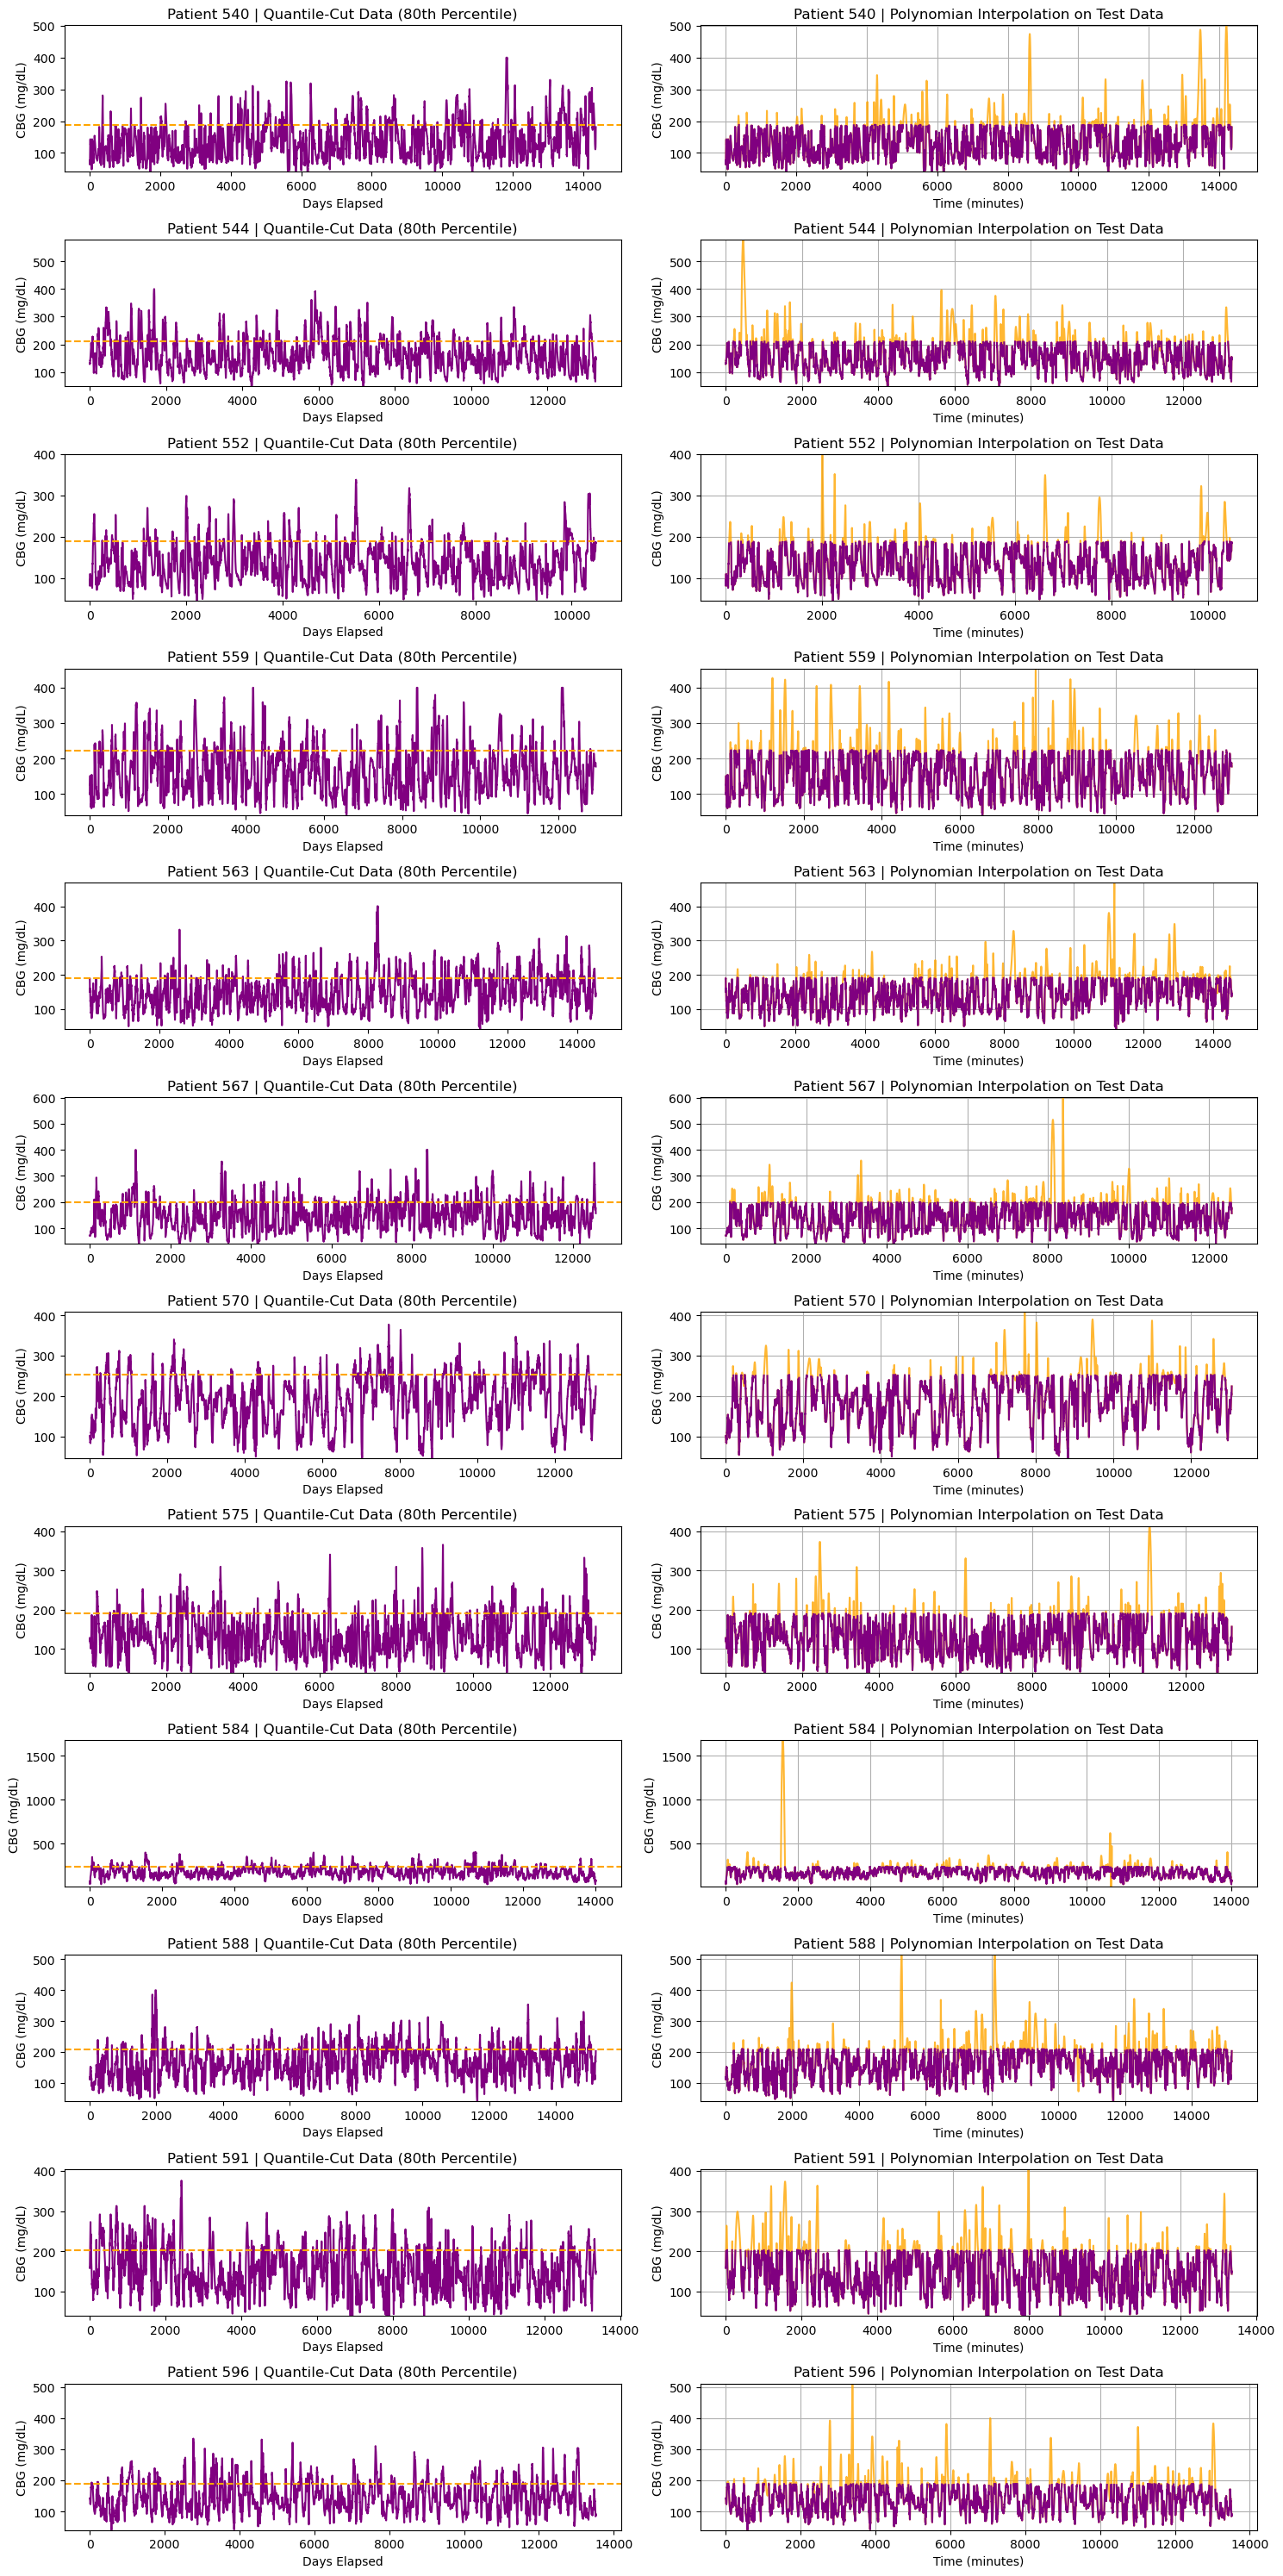

In [41]:
visualize_original_interpolated(interpolated_segments_poly, cleaned_censored_segments, cleaned_original_segments, method_name = 'Polynomian')

**Cubic Splines**<br>

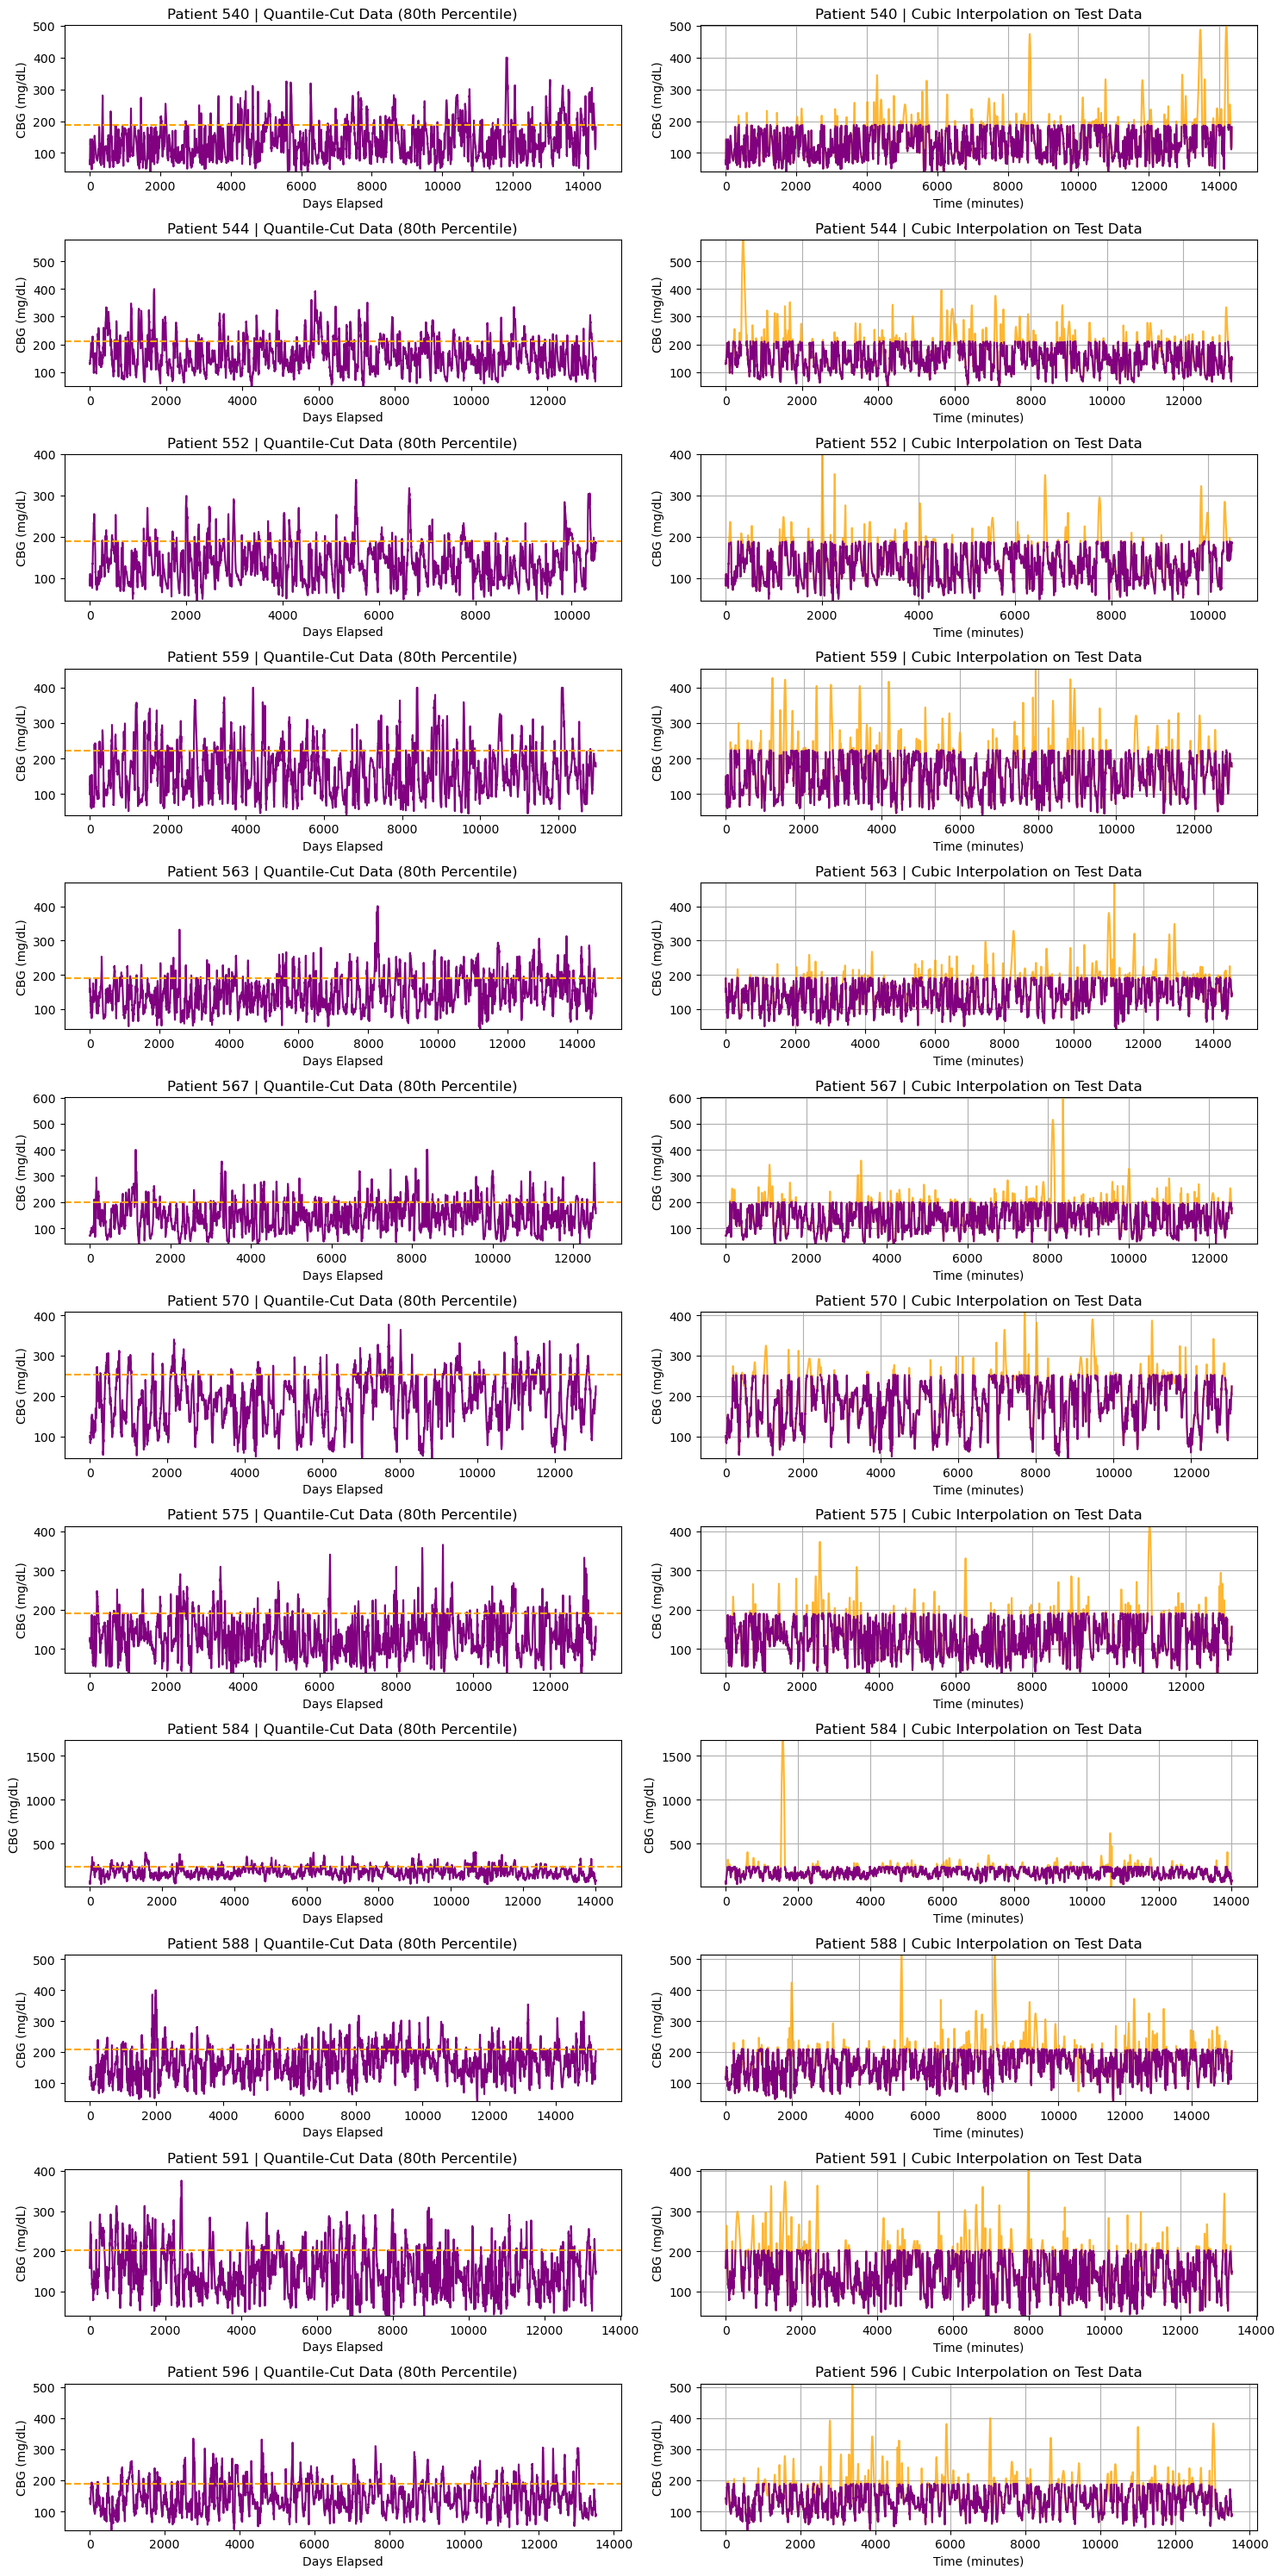

In [42]:
interpolated_segments_cubic = naive_baseline_imputation(data=cleaned_censored_segments, method='cubic')
visualize_original_interpolated(interpolated_segments_cubic, cleaned_censored_segments, cleaned_original_segments, method_name = 'Cubic')

**Common CGM Statistics**<br>
We evaluate the effectiveness of different interpolation methods by comparing key CGM metrics, including the mean and standard deviation of glucose levels before and after imputation. We calculate these statistics for both the original and interpolated data across training and validation sets.

In [43]:
original_stats = calculate_mean_sd(cleaned_original_segments)
interpolated_stats_poly = calculate_mean_sd(interpolated_segments_poly)
interpolated_stats_cubic = calculate_mean_sd(interpolated_segments_cubic)

In [44]:
compare_statistics(original_stats, interpolated_stats_poly, 'Polynomial')

Original Mean  Original SD  Interpolated Mean  Interpolated SD  \
540     138.047858    55.973504         140.160396        64.442326   
544     162.864818    58.413923         164.051095        64.018075   
552     136.566749    46.269265         137.085145        48.061606   
559     164.303255    68.161414         164.833866        70.450257   
563     149.127355    49.519296         148.926414        50.813379   
567     146.969280    56.095792         147.341976        59.839614   
570     187.716945    60.912082         187.545579        61.645577   
575     132.528298    49.393403         133.486174        52.968825   
584     181.570603    58.875053         188.201574       114.632236   
588     165.662350    49.674765         167.101471        56.741728   
591     151.841577    55.421710         152.589664        58.348136   
596     146.697115    49.061675         148.206624        55.599216   

     Mean Difference  SD Difference  
540         2.112538       8.468823  
544         1.186277       5.604152  
552         0.518396       1.792341  
559         0.530612       2.288843  
563        -0.200941       1.294083  
567         0.372697       3.743821  
570        -0.171366       0.733495  
575         0.957876       3.575422  
584         6.630971      55.757183  
588         1.439122       7.066963  
591         0.748087       2.926426  
596         1.509508       6.537541

In [45]:
compare_statistics(original_stats, interpolated_stats_cubic, 'Cubic')

Original Mean  Original SD  Interpolated Mean  Interpolated SD  \
540     138.047858    55.973504         140.160396        64.442326   
544     162.864818    58.413923         164.051095        64.018075   
552     136.566749    46.269265         137.085145        48.061606   
559     164.303255    68.161414         164.833866        70.450257   
563     149.127355    49.519296         148.926414        50.813379   
567     146.969280    56.095792         147.341976        59.839614   
570     187.716945    60.912082         187.545579        61.645577   
575     132.528298    49.393403         133.486174        52.968825   
584     181.570603    58.875053         188.201574       114.632236   
588     165.662350    49.674765         167.101471        56.741728   
591     151.841577    55.421710         152.589664        58.348136   
596     146.697115    49.061675         148.206624        55.599216   

     Mean Difference  SD Difference  
540         2.112538       8.468823  
544         1.186277       5.604152  
552         0.518396       1.792341  
559         0.530612       2.288843  
563        -0.200941       1.294083  
567         0.372697       3.743821  
570        -0.171366       0.733495  
575         0.957876       3.575422  
584         6.630971      55.757183  
588         1.439122       7.066963  
591         0.748087       2.926426  
596         1.509508       6.537541

**Gaussian Process Regression**

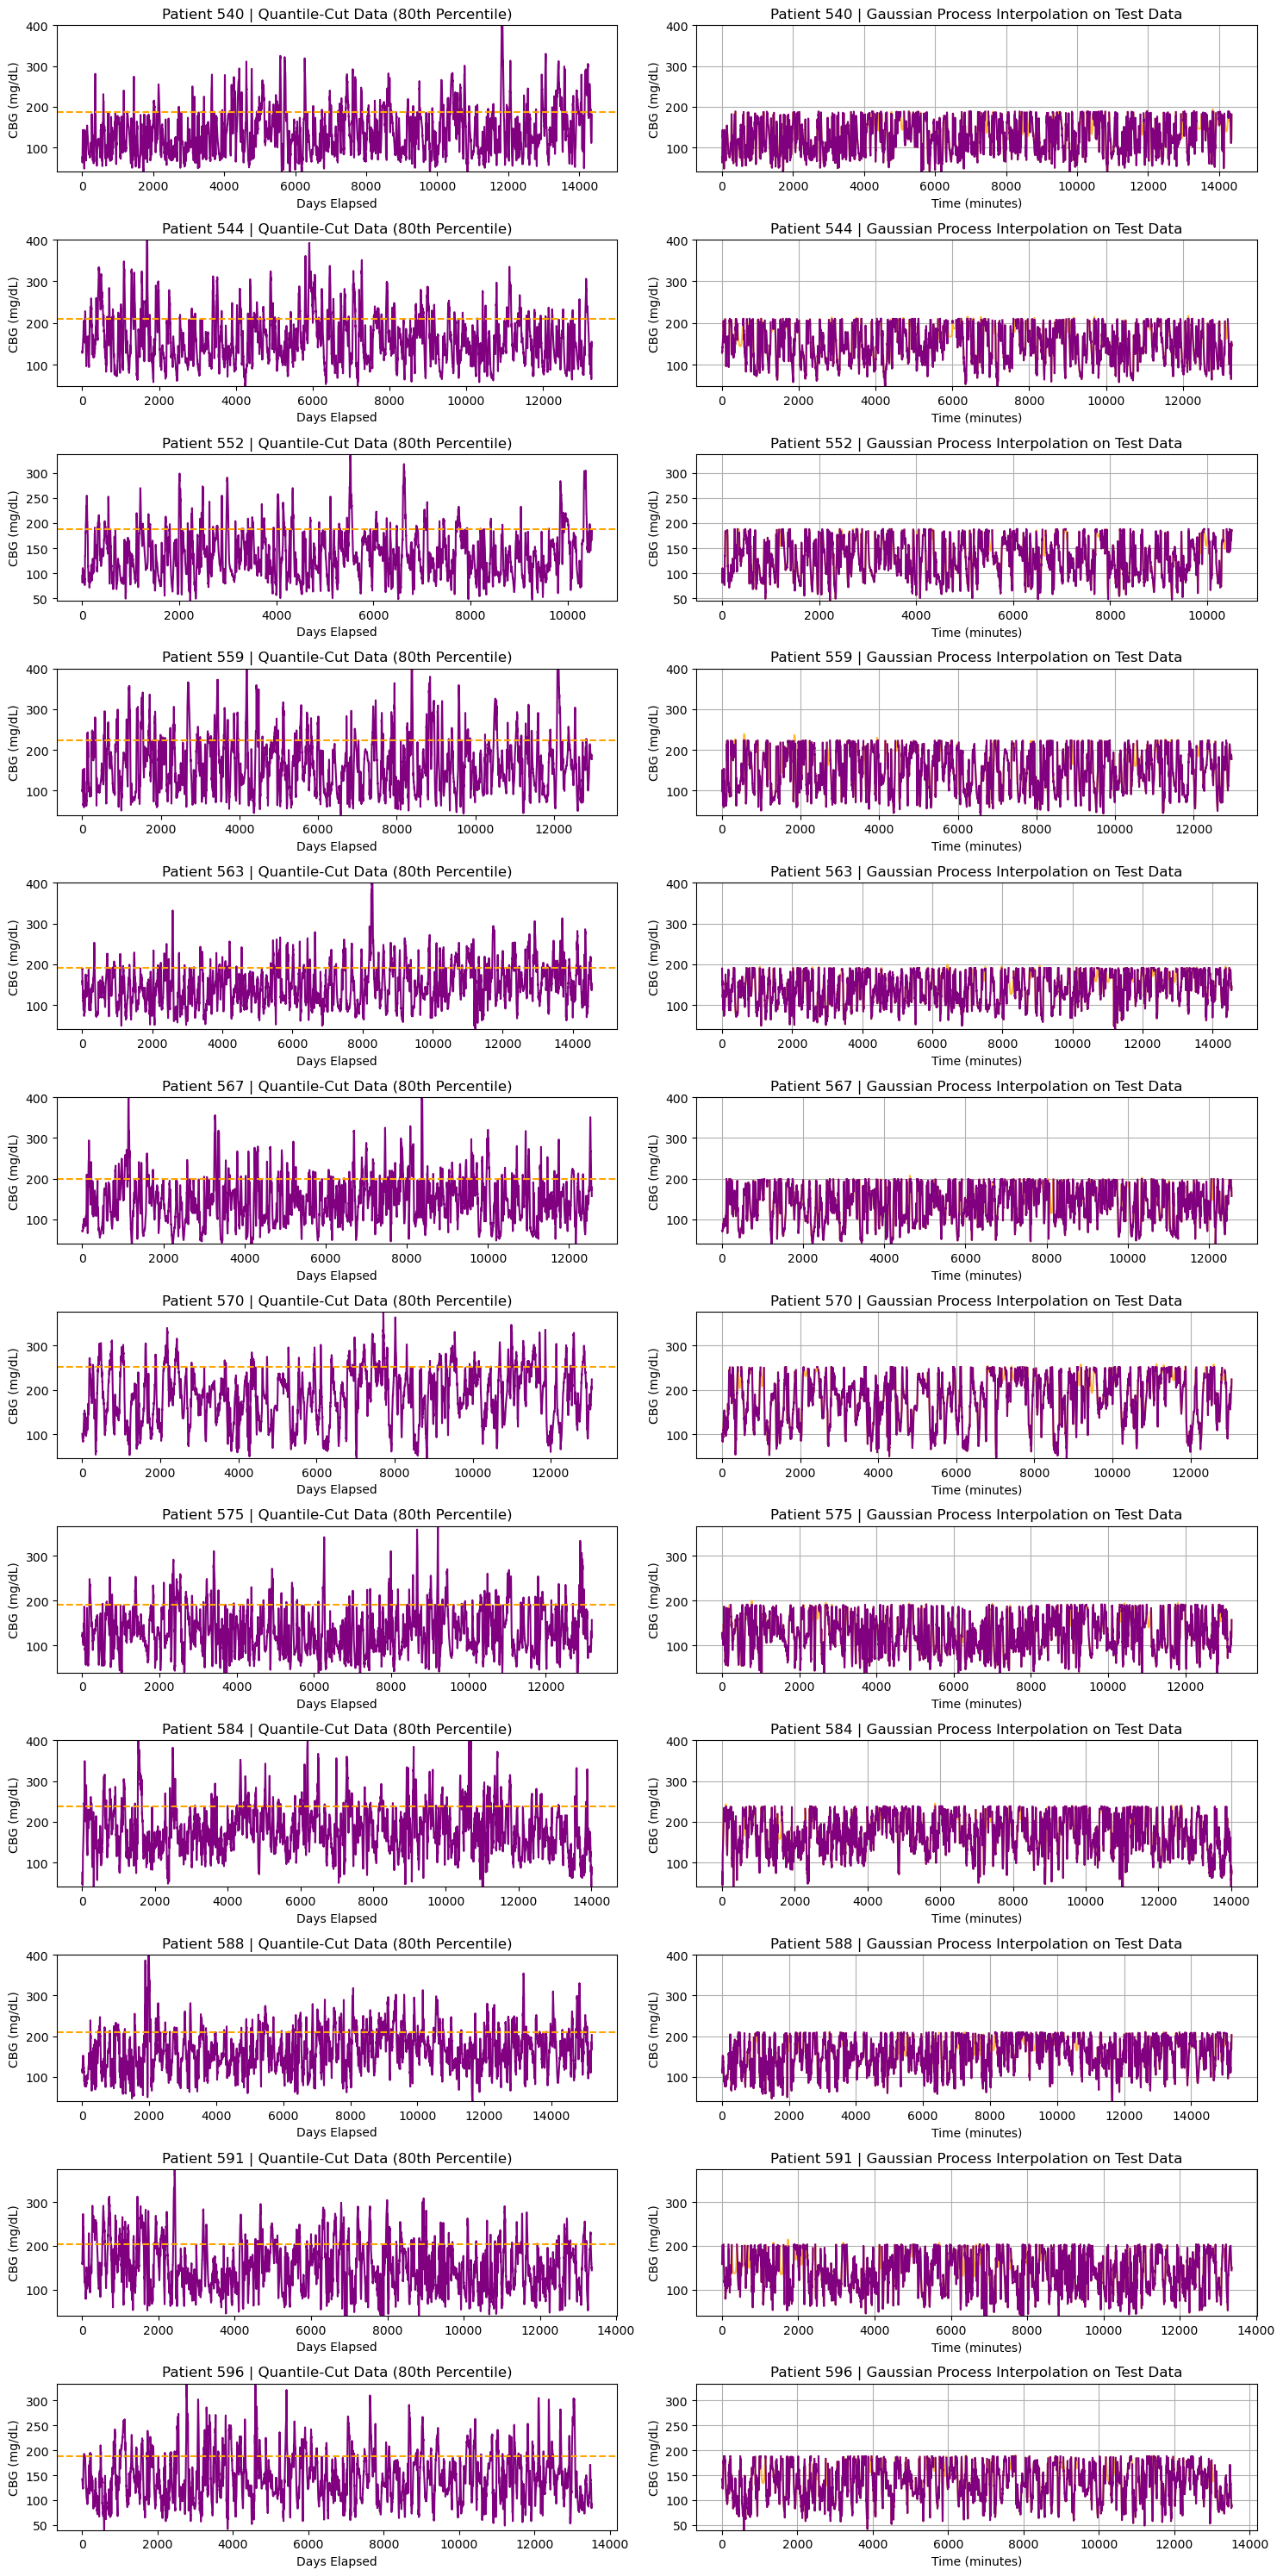

In [46]:
interpolated_segments_gp = {}
for patient_id, segments in cleaned_censored_segments.items():
    interpolated_segments_gp[patient_id] = []
    segment_no = 0
    for segment in segments:
        # Convert segment to DataFrame to use interpolation functions
        segment_df = pd.DataFrame(segment, columns=['cbg'])

        # Check if there are any NaN values in the segment
        if segment_df['cbg'].isna().any():
            # Only train and infer if there are NaN values
            gpr = train_gpr(np.array(segment_df), 'gpr_' + str(patient_id) + '_' + str(segment_no), kernel=None)
            indices, interpolated_segment, std = inference_gpr(np.array(segment_df), gpr)
            
            # Create a copy of the original segment and replace NaNs with interpolated values
            indices = indices.flatten()  # Ensure `indices` is a flat array
            full_interpolated_segment = np.array(segment_df).flatten().copy()

            full_interpolated_segment[indices] = np.array(interpolated_segment).flatten()  # Replace NaNs with interpolated values
            
            interpolated_segments_gp[patient_id].append(full_interpolated_segment)
        else:
            # If no NaN values, add the original segment without modification
            interpolated_segments_gp[patient_id].append(np.array(segment_df).flatten())
        
        segment_no += 1

visualize_original_interpolated(interpolated_segments_gp, cleaned_censored_segments, cleaned_original_segments, method_name = 'Gaussian Process')

# SAving the output of the inference
# with open('inference_540.pkl', 'wb') as f:
#     pickle.dump((indices, predicted, std), f)

In [ ]:
interpolated_stats_gp = calculate_mean_sd(interpolated_segments_gp)
compare_statistics(original_stats, interpolated_stats_gp, 'GP')

Original Mean  Original SD  Interpolated Mean  Interpolated SD  \
540     138.047858    55.973504         126.806867        37.635356   
544     162.864818    58.413923         150.836559        39.941493   
552     136.566749    46.269265         130.424004        35.378826   
559     164.303255    68.161414         151.302557        48.169589   
563     149.127355    49.519296         140.273879        35.812171   
567     146.969280    56.095792         138.200425        41.480439   
570     187.716945    60.912082         181.357332        52.275544   
575     132.528298    49.393403         126.648960        39.134710   
584     181.570603    58.875053         171.820880        43.425685   
588     165.662350    49.674765         156.117425        36.001288   
591     151.841577    55.421710         140.872360        40.448653   
596     146.697115    49.061675         136.734339        34.178257   

     Mean Difference  SD Difference  
540       -11.240991     -18.338148  
544       -12.028259     -18.472429  
552        -6.142745     -10.890438  
559       -13.000698     -19.991826  
563        -8.853476     -13.707125  
567        -8.768855     -14.615353  
570        -6.359613      -8.636538  
575        -5.879337     -10.258693  
584        -9.749723     -15.449368  
588        -9.544924     -13.673477  
591       -10.969217     -14.973057  
596        -9.962777     -14.883418